# Learning with SARSA($\lambda$) & Linear function approximation 

## Yue Dong & Ali Emami
In this assignment, Ali and I want to demonstrate the experiments of performing SARSA($\lambda$) using linear function approximation. We use the SARSA algorithm for on-policy control, implemented using the backward-view (eligibility traces).

The difference of using linear function approximation in SARSA is that the action-value function Q(s,a) is approximated linearly by the function
$$Q(s,a,W)= \phi(s,a)^T * W$$ where W is a vector and $\phi$ a vector representing features.

## 1. Learning Easy21 with SARSA($\lambda$) and linear function approximation

The environment are defined in the script easy21game.py. The easy 21 is a simplified version of blackjack where the following rules are use:

- In each round, we draw cards with replacement from an infinite deck of cards. 
- Each draw results in a black (prob. 2/3) or red (prob. 2/3) card with values among 1 to 10. So there is no usable ace or face cards.
- At the beginning of the game, both player and dealer can only draw one black card
- Each turn the player may either stick or hit, hit means the player will draw another card, until he/she stick and the player side ends.
- Then the value of black cards are added and the value of red card are subtracted. 
- busted and lose the game if player's sum exceeds 21 or smaller than 1. Lose the game and receive reward -1.
- Otherwise, dealer's turn. dealer plays a fixed policy of sticks on any sum greater or equals to 17. If the dealer goes bust, then the player wins; otherwise, compare dealer's and player's card and the outcome is – win (reward +1), lose (reward -1), or draw (reward 0).

### Linear function approximation
To use linear function approximation, we define $\phi$ and W to be a vector of length 36. 
$\phi(s,a)$ is a binary feature vector with $3*6*2 = 36$ features. Each binary feature
 has a value of 1 if (s,a) lies within the cuboid of state-space corresponding to
 that feature, and the action corresponding to that feature. The cuboids have
 the following overlapping intervals:
   - dealer(s) = [1: 4]; [4: 7]; [7: 10]
   - player(s) = [1: 6]; [4: 9]; [7: 12]; [10: 15]; [13: 18]; [16: 21]
   - a = 1 (hit); a = 0 (stick)





In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 22 22:08:39 2017

@author: yuedong
"""

import os
os.chdir("/Users/yuedong/Downloads/comp767_easy21LA/")
#%%

from easy21game import Easy21
import numpy as np
from matplotlib import cm
#%%
env = Easy21()

#%% code the state-action paris into features

# INPUT
#   dealerState: card value of the dealer, integer between 1 and 10
# OUTPUT
#   boolean vector coding the dealer card to 3 intervals
def dealerFeatures(dealerState):
    dealerVec = np.array([dealerState in [1,2,3,4], dealerState in [4,5,6,7], 
                   dealerState in [7,8,9,10]]).astype('int')
    return np.where(dealerVec)[0]
  
    
# INPUT
#   playerState: sum of the player, integer between 1 and 21
# OUTPUT
#   boolean vector coding the player card interval on 6 bits
def playerFeatures(playerState):
    playerVec = np.array([playerState in [1,2,3,4,5,6], 
                     playerState in [4,5,6,7,8,9],
                     playerState in [7,8,9,10,11,12],
                     playerState in [10,11,12,13,14,15],
                     playerState in [13,14,15,16,17,18],
                     playerState in [16,17,18,19,20,21]]).astype('int')
    return np.where(playerVec)[0]


# INPUTS
#   s: state =(playerState,dealerState) (as defined in env._step)
#   a: action, integer: HIT(1) or STICK(0)
# returns a binary vector of length 36 representing the features
def phi(s, a):
    tmp = np.zeros(shape=(3,6,2)) #zeros array of dim 3*6*2
    #putting one where a feature is on
    for i in dealerFeatures(s[1]):
        for j in playerFeatures(s[0]):
            tmp[i,j,a] = 1 
    return(tmp.flatten()) #returning 'vectorized' (1-dim) array
#%%
class Sarsa_Agent:
    def __init__(self, environment, mlambda, gamma=1, step_size=0.01):

        self.env = environment
        self.mlambda = mlambda
        self.gamma = gamma
        self.step_size = step_size
        #initialize everything
#        self.Q = np.zeros((self.env.dealer_space,
#                           self.env.player_space, 
#                           self.env.nA))
         
        self.V = np.zeros((self.env.dealer_space,
                           self.env.player_space))
        
        self.W = np.zeros(36)
        self.E = np.zeros(36)
        
        self.iterations = 0
        
        
    # Q is simply the dot product of phi and w
    def cal_Q(self,s,a):
        return np.dot(phi(s,a),self.W)


          # get optimal action based on ε-greedy exploration strategy  
    def epsilon_greedy_action(self, state, epsilon=0.05):
        # action = 0 stick
        # action = 1 hit
        hit = 1
        stick = 0
        # epsilon greedy policy
        if np.random.random() < epsilon:
            r_action = hit if np.random.random()<0.5 else stick
            return r_action
        else:
            action = np.argmax([self.cal_Q(state,0),self.cal_Q(state,1)])
            return action
        
    
    def train(self, iterations):        
        # Loop episodes
        for episode in range(iterations):
            self.E = np.zeros(36)

            # get initial state for current episode
            s = self.env._reset()
            a = self.epsilon_greedy_action(s)
            a_next = a
            term = False
            #r = 0
            
            # Execute until game ends
            while not term:
                
                # execute action
                s_next, r, term = self.env._step(a)[0:3]
                q = self.cal_Q(s,a)
                                
                if not term:
                    # choose next action with epsilon greedy policy
                    a_next = self.epsilon_greedy_action(s_next)
                    q_next = self.cal_Q(s_next,a_next)
                    delta = r + self.gamma * q_next - q
                else:
                    delta = r - q
                
                
                self.E =  self.gamma * self.mlambda * self.E +phi(s,a)
                self.W = self.W + self.step_size * delta * self.E

                # reassign s and a
                s = s_next
                a = a_next


        self.iterations += iterations

        # Derive value function
        for d in range(self.env.dealer_space):
            for p in range(self.env.player_space):
                self.V[d,p] = max([self.cal_Q((p+1,d+1),0),self.cal_Q((p+1,d+1),1)])
                
    def plot_frame(self, ax):
        def get_stat_val(x, y):
            return self.V[x, y]

        X = np.arange(0, self.env.dealer_space, 1)
        Y = np.arange(0, self.env.player_space, 1)
        X, Y = np.meshgrid(X, Y)
        Z = get_stat_val(X, Y)
        
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=cm.coolwarm, linewidth=0, antialiased=False)
        return surf
#%%

agent = Sarsa_Agent(env, 0.5)
#%%
for i in range (1):
    agent.train(10000)

#print("learned values:",agent.V)
#agent.W

('done ', 0, 1, 0)
('done ', 0, 1, 1)
('done ', 1, 2, 2)
('done ', 2, 4, 4)
('done ', 3, 8, 8)
('done ', 4, 16, 16)
('done ', 5, 32, 32)
('done ', 6, 64, 64)
('done ', 7, 128, 128)
('done ', 8, 256, 256)
('done ', 9, 512, 512)
('done ', 10, 1024, 1024)
('done ', 11, 2048, 2048)
('done ', 12, 4096, 4096)
('done ', 13, 8192, 8192)
('done ', 14, 16384, 16384)
('done ', 0, 32768, 32768)


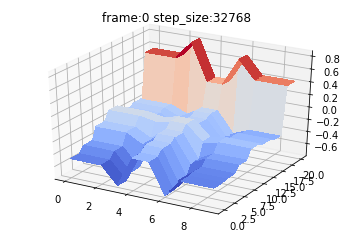

In [5]:
def animate(frame):
    i = agent.iterations
    step_size = i
    step_size = max(1, step_size)
    step_size = min(step_size, 2 ** 16)
    agent.train(step_size)

    ax.clear()
    surf =  agent.plot_frame(ax)
    plt.title('frame:%s step_size:%s ' % (frame, step_size) )
    # plt.draw()
    fig.canvas.draw()
    print("done ", frame, step_size, i)
    return surf

#%%
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline 


mlambda = 0.2
agent = Sarsa_Agent(env,mlambda)
fig = plt.figure("N100")
ax = fig.add_subplot(111, projection='3d')

# ani = animation.FuncAnimation(fig, animate, 32, repeat=False)
ani = animation.FuncAnimation(fig, animate, 15, repeat=False)

# note: requires gif writer; swap with plt.show()
ani.save('Sarsa_Agent_py.gif', writer='imagemagick', fps=3)
# plt.show()

In [8]:
from IPython.display import Image
Image(url="Sarsa_Agent_py.gif")

## Discussion and Results

In [45]:
from IPython.display import Image
Image(url="comparison_with_different_lambda.png")

The above graph compares different algorithms we used for Easy21. 

- learning with different $\lambda$ makes a difference in learning, lower to intermediate values are learning better (0 to 0.4). We could conclude that MC control ($\lambda=1$) is learning the slowest among all different lambda values because MC has the highest variance among all sarsa($\lambda$) leaners. 

- With less variables to learn, function approximation decreases learning time in Easy21. Our last assignment presented the result without function approximation.  At iteration 3000, most values are still not accurate yet. In this assignment, at step 3000, we could see that the values are well approximations of the optimal values. 

- However, the fast learning is at the cost of some precision since the features are generalized.  The overlapping regions led to strange results, likely caused by having had certain states triggering multiple regions, and having the sum of their weights lead to values greater than one.  These regions should be removed—no significant benefit was observed from them.